In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]

In [5]:
df = df.fillna(0)

In [9]:
df['median_house_value'] = np.log1p(df['median_house_value'])

In [14]:
df_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [18]:
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)

In [19]:
X_train.shape

(9411, 10)

Question 1

In [23]:
dt = DecisionTreeRegressor(max_depth=1)

In [24]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [25]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Question 2

In [28]:
rf = RandomForestRegressor(n_estimators=10,
random_state=1,
n_jobs=-1)

In [29]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [30]:
y_pred = rf.predict(X_val)

In [32]:
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [33]:
rmse

0.24459962783255346

Question 3

In [35]:
score = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    score.append([n, rmse])
    
score = pd.DataFrame(score, columns=['n_etimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

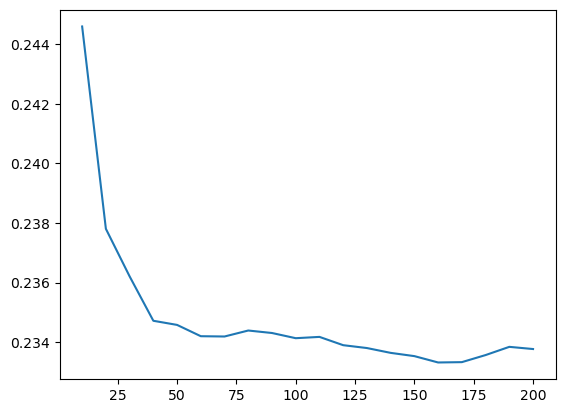

In [38]:
plt.plot(score.n_etimators, score.rmse)

In [40]:
score = []

for d in tqdm([10, 15, 20, 25]):
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    random_state=1,
                                  max_depth=d)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        score.append([d, n, rmse])

score = pd.DataFrame(score, columns=['max_depth', 'n_etimators', 'rmse'])

  0%|          | 0/4 [00:00<?, ?it/s]

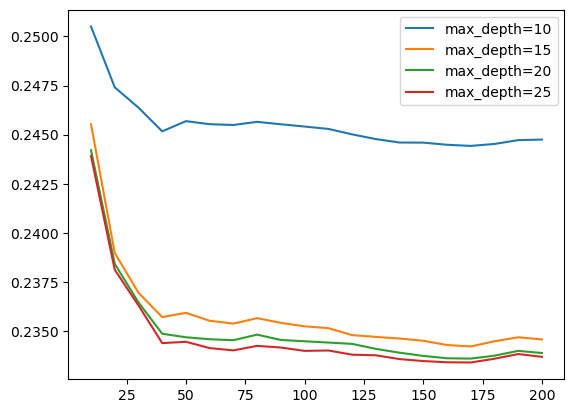

In [43]:
for d in  [10, 15, 20, 25]:
    df_subset = score[score.max_depth == d]
    
    plt.plot(df_subset.n_etimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

In [44]:
for d in  [10, 15, 20, 25]:
    df_subset = score[score.max_depth == d]
    print(d, np.mean(df_subset.rmse))

10 0.24549891035241106
15 0.23581606737807745
20 0.2350456991247855
25 0.23471302200772706


Question 5

In [46]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)

In [48]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [49]:
importances = rf.feature_importances_

In [50]:
importances

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [75]:
features = dv.get_feature_names_out()

In [79]:
features

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

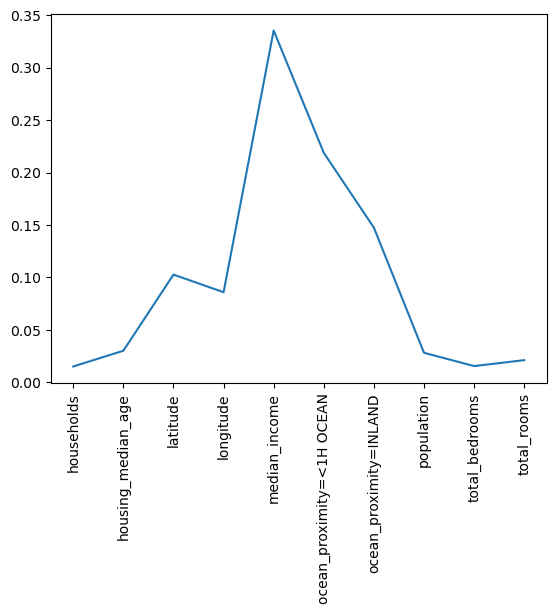

In [77]:
plt.plot(features, importances)
plt.xticks(rotation=90)

Question 6

In [59]:
!pip install xgboost

     ---------------------------------------- 99.7/99.7 MB 6.4 MB/s eta 0:00:00


In [60]:
import xgboost as xgb

In [61]:
features = dv.get_feature_names_out()

In [63]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [64]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [65]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [66]:
y_pred = model.predict(dval)

In [67]:
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [68]:
rmse

0.228623199980106

In [69]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [70]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [71]:
y_pred = model.predict(dval)

In [72]:
rmse = mean_squared_error(y_val, y_pred, squared=False)

In [73]:
rmse

0.23208927121609343

In [74]:
features

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=<1H OCEAN',
       'ocean_proximity=INLAND', 'population', 'total_bedrooms',
       'total_rooms'], dtype=object)